# Importing Libraries and Datasets

In [1]:
# Data Processing
import numpy as np
import pandas as pd
import wget
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import folium
%matplotlib inline

# Ploting Offline
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

# Hide Warnings
import warnings
warnings.filterwarnings('ignore')

# File and Folder Operations
import os


# Modeling
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.tsa.arima_model import ARIMA
np.random.seed(42)

# Prediction
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from datetime import timedelta
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor

In [2]:
lastday = datetime.today() - timedelta(days=1)
lastday = lastday.strftime('%m-%d-%Y')

In [3]:
lastday

'11-27-2022'

In [4]:
# url of the raw csv dataset
urls = [
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
    f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{lastday}.csv'
]
[wget.download(url) for url in urls]

100% [......................................................] 1126300 / 1126300

100% [........................................................] 555983 / 555983

['time_series_covid19_confirmed_global (6).csv',
 'time_series_covid19_deaths_global (6).csv',
 '11-27-2022 (1).csv']

In [5]:
confirmed_df = pd.read_csv(r'time_series_covid19_confirmed_global.csv')
death_df = pd.read_csv(r'time_series_covid19_deaths_global.csv')
latest_data = pd.read_csv(f'{lastday}.csv')

# Data Processing 
## Merging the Datasets

In [6]:
dates = confirmed_df.columns[4:]

In [7]:
confirmed_mrg = confirmed_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Confirmed'
)

death_mrg = death_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Deaths'
)

In [8]:
# Merging confirmed_df_long and death_df_long
full_table = confirmed_mrg.merge(
  right=death_mrg, 
  how='left',
  on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long']
)

In [113]:
full_table.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,WHO region
0,,Afghanistan,33.939,67.710,2020-01-22,0,0,EMRO
1,,Albania,41.153,20.168,2020-01-22,0,0,EURO
2,,Algeria,28.034,1.660,2020-01-22,0,0,AFRO
3,,Andorra,42.506,1.522,2020-01-22,0,0,EURO
4,,Angola,-11.203,17.874,2020-01-22,0,0,AFRO


In [115]:
full_table.tail()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,WHO region
300554,,Vietnam,14.058,108.277,2022-11-26,11514174,43170,WPRO
300555,,West Bank and Gaza,31.952,35.233,2022-11-26,703036,5708,EMRO
300557,,Yemen,15.553,48.516,2022-11-26,11945,2159,EMRO
300558,,Zambia,-13.134,27.849,2022-11-26,333721,4019,AFRO
300559,,Zimbabwe,-19.015,29.155,2022-11-26,257893,5606,AFRO


## Cleaning the Datasets
There are 3 tasks we would like to do:
- Converting Date from string to datetime
- Replacing missing value NaN
- Coronavirus cases reported from 3 cruise ships should be treated differently

In [9]:
full_table['Date'] = pd.to_datetime(full_table['Date'])

In [10]:
full_table.isna().sum()

Province/State    205920
Country/Region         0
Lat                 2080
Long                2080
Date                   0
Confirmed              0
Deaths                 0
dtype: int64

Their are NaN values in Provision/State since many countries only report country wise.

These data need to be extracted and treated differently due to Province/State and Country/Region mismatch over time.

In [11]:
ship_rows = full_table['Province/State'].str.contains('Grand Princess') | full_table['Province/State'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('MS Zaandam')

In [12]:
ship_df = full_table[ship_rows]
ship_df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths
42,Diamond Princess,Canada,0.0,0.0,2020-01-22,0,0
43,Grand Princess,Canada,0.0,0.0,2020-01-22,0,0
106,NaN,Diamond Princess,0.0,0.0,2020-01-22,0,0
175,NaN,MS Zaandam,0.0,0.0,2020-01-22,0,0
331,Diamond Princess,Canada,0.0,0.0,2020-01-23,0,0


In [13]:
full_table = full_table[~(ship_rows)]

## Preprocessing the Dataset

In [14]:
# Checking for missing values in each column in percentage

number_of_columns = full_table.shape[0]
percentage_of_missing_data = full_table.isnull().sum()/number_of_columns
print(percentage_of_missing_data)

Province/State    0.687719
Country/Region    0.000000
Lat               0.007018
Long              0.007018
Date              0.000000
Confirmed         0.000000
Deaths            0.000000
dtype: float64


In [15]:
# handling the missing values of the column 'province/state' with ''
full_table['Province/State'] = full_table['Province/State'].fillna('')

# changing the countries' names
full_table['Country/Region'] = full_table['Country/Region'].replace('Korea, South', "South Korea")
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')
full_table['Country/Region'] = full_table['Country/Region'].replace('Taiwan*', 'Taiwan')
full_table['Country/Region'] = full_table['Country/Region'].replace('Congo (Kinshasa)', 'Democratic Republic of the Congo')
full_table['Country/Region'] = full_table['Country/Region'].replace('Congo (Brazzaville)', 'Republic of the Congo')
full_table.loc[full_table['Province/State']=='Greenland', 'Country/Region'] = 'Greenland'
full_table.tail()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths
300555,,West Bank and Gaza,31.952200,35.233200,2022-11-26,703036,5708
300556,,Winter Olympics 2022,39.904200,116.407400,2022-11-26,535,0
300557,,Yemen,15.552727,48.516388,2022-11-26,11945,2159
300558,,Zambia,-13.133897,27.849332,2022-11-26,333721,4019
300559,,Zimbabwe,-19.015438,29.154857,2022-11-26,257893,5606


In [16]:
print(full_table['Date'].describe(),'\n')

# We should convert the dates to appropriate format for further use such as visualization
#.dt.normalize() is just to change display from 2022-11-24 00:00:00 to 2022-11-24

full_table['Date'] = pd.to_datetime(full_table['Date']).dt.normalize()

print(full_table['Date'].describe())
full_table['Date']

count                  296400
unique                   1040
top       2020-01-22 00:00:00
freq                      285
first     2020-01-22 00:00:00
last      2022-11-26 00:00:00
Name: Date, dtype: object 

count                  296400
unique                   1040
top       2020-01-22 00:00:00
freq                      285
first     2020-01-22 00:00:00
last      2022-11-26 00:00:00
Name: Date, dtype: object


0        2020-01-22
1        2020-01-22
2        2020-01-22
3        2020-01-22
4        2020-01-22
            ...    
300555   2022-11-26
300556   2022-11-26
300557   2022-11-26
300558   2022-11-26
300559   2022-11-26
Name: Date, Length: 296400, dtype: datetime64[ns]

## Obtain the WHO regions according to Country names

In [17]:
# Loading the WHO Region Dataset

WHO_regions = pd.read_csv('/Users/masoomajafari/Desktop/HK/5th Semester/Predictive Analytics/FINAL_EXAM/PGR304ProjectAutumn 22_1005/DATA/WHO_regions.csv')
WHO_regions.head()

,Country,Region Name
0,A,NaN
1,Afghanistan,EMRO
2,Albania,EURO
3,Algeria,AFRO
4,Andorra,EURO


In [18]:
# Appending the dataframe WHO_regions to dictionary
new_who=WHO_regions.copy()
new_who=new_who.set_index('Country').T.to_dict('list')

# Appending the WHO region column from the WHO_regions dataset
for k, v in new_who.items():
    full_table.loc[(full_table['Country/Region'] == k), 'WHO region'] = v[0]

# Looking for any missing data
print(full_table[full_table['WHO region'].isna()]['Country/Region'].unique().tolist())

['Antarctica', 'Antigua and Barbuda', 'Brunei', 'Burma', 'Cabo Verde', 'Republic of the Congo', "Cote d'Ivoire", 'Czechia', 'Greenland', 'Eswatini', 'Holy See', 'Iran', 'Korea, North', 'South Korea', 'Kosovo', 'Laos', 'Liechtenstein', 'Micronesia', 'Moldova', 'North Macedonia', 'Russia', 'Sao Tome and Principe', 'Summer Olympics 2020', 'Syria', 'Taiwan', 'Tanzania', 'US', 'Vietnam', 'West Bank and Gaza', 'Winter Olympics 2022']


In [19]:
# Handling the missing values in the WHO region

who_exceptions={'Antigua and Barbuda':'PAHO', 'Brunei':'WPRO', 'Cabo Verde':'AFRO', 'Republic of the Congo':'AFRO',
 "Cote d'Ivoire":'AFRO', 'Czechia':'EURO', 'Greenland':'EURO', 'Eswatini':'AFRO', 'Holy See':'EURO', 'Iran':'EMRO',
 'South Korea':'WPRO', 'Liechtenstein':'EURO', 'Moldova':'EURO', 'North Macedonia':'EURO', 'Russia':'EURO',
 'Taiwan':'WPRO', 'Tanzania':'AFRO', 'US':'PAHO', 'Vietnam':'WPRO', 'Syria':'EMRO', 'Laos':'WPRO', 
'West Bank and Gaza':'EMRO', 'Kosovo':'EURO', 'Burma':'SEARO', 'Western Sahara':'AFRO', 'Sao Tome and Principe':'AFRO',
                'Korea, North':'SEARO', 'Micronesia':'WPRO'}

for k, v in who_exceptions.items():
    full_table.loc[(full_table['Country/Region'] == k), 'WHO region'] = v
    
# Searching for missing data if any
print(full_table[full_table['WHO region'].isna()]['Country/Region'].unique())

['Antarctica' 'Summer Olympics 2020' 'Winter Olympics 2022']


In [20]:
full_table = full_table[full_table['Country/Region'] != 'Antarctica']
full_table = full_table[full_table['Country/Region'] != 'Summer Olympics 2020']
full_table = full_table[full_table['Country/Region'] != 'Winter Olympics 2022']

In [21]:
# Searching for missing data if any
print(full_table[full_table['Country/Region'] != 'Winter Olympics 2022'][full_table['WHO region'].isna()]['Country/Region'].unique())

[]


In [22]:
# Saving the main_df as a csv file
full_table.to_csv('covid19_full_cleaned.csv', index=False)

In [23]:
# We can group the datasets "covid19_full_cleaned" by Country/Region & Date
country_df = full_table.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths'].sum()\
                                .reset_index()

In [24]:
# Adding new column New Cases, New Deaths
new_col = country_df.groupby(['Country/Region', 'Date'])['Confirmed', 'Deaths'].sum()\
                                    .diff().reset_index()

In [25]:
# Renamming some columns of new_col
new_col.columns = ['Country/Region', 'Date', 'New confirmed', 'New deaths']
columns = ['New confirmed', 'New deaths']

In [26]:
# Preparing the value of first row of each country
first_rows = (new_col['Country/Region'] != new_col['Country/Region'].shift(1))
new_col.loc[first_rows, 'New confirmed'] = 0
new_col.loc[first_rows, 'New deaths'] = 0

In [27]:
# Merging new values
country_df = pd.merge(country_df, new_col, on=['Country/Region', 'Date'])

In [28]:
# Filling the missing values with 0
country_df = country_df.fillna(0)

country_df['New confirmed'] = country_df['New confirmed'].apply(lambda x: 0 if x<0 else x)

In [29]:
# Changing the datatypes of new columns
country_df[columns] = country_df[columns].astype('int')

In [30]:
# Adding the 'WHO region' column
for k, v in new_who.items():
    country_df.loc[(country_df['Country/Region'] == k), 'WHO region'] = v[0]
    
for k, v in who_exceptions.items():
    country_df.loc[(country_df['Country/Region'] == k), 'WHO region'] = v

In [31]:
# Checking for the missing values if any
print(country_df[country_df['WHO region'].isna()]['Country/Region'].unique())

[]


In [32]:
# Printing first few rows
country_df.head()

,Date,Country/Region,Confirmed,Deaths,New confirmed,New deaths,WHO region
0,2020-01-22,Afghanistan,0,0,0,0,EMRO
1,2020-01-22,Albania,0,0,0,0,EURO
2,2020-01-22,Algeria,0,0,0,0,AFRO
3,2020-01-22,Andorra,0,0,0,0,EURO
4,2020-01-22,Angola,0,0,0,0,AFRO


In [33]:
# Saving the dataframe as .csv file
country_df.to_csv('country_df.csv', index=False)

# Data Analysis & Visualization
## Current World Situation

In [34]:
# Creating "samp" and groupping on Date to get total current values 
samp = country_df.groupby('Date')['Confirmed', 'Deaths'].sum().reset_index()
samp = samp[samp['Date']==max(samp['Date'])].reset_index(drop=True)
world_cases = samp.to_numpy()
samp.style.background_gradient(cmap='viridis')

,Date,Confirmed,Deaths
0,2022-11-26 00:00:00,641334700,6630266


In [35]:
# Showing the countries with maximum no of cases
samp = country_df.groupby(['Country/Region'])['Confirmed', 'Deaths', 'New confirmed', 'New deaths'].max()
samp.sort_values('Confirmed', ascending=False).style.bar(subset=['Confirmed', 'Deaths', 'New confirmed', 'New deaths'],
                                                         align = 'left', color='#5f91d6')

,Confirmed,Deaths,New confirmed,New deaths
Country/Region,,,,
US,98564494,1079197,1355242,4389
India,44672787,530612,414188,7374
France,37789817,159679,503349,1438
Germany,36373164,157495,527487,1244
Brazil,35149503,689442,287149,4148
South Korea,26937516,30369,621317,470
United Kingdom,24591146,212585,848169,1492
Japan,24394223,49044,260999,350
Italy,24260660,181098,229122,993


# Worldwide Number of Confirmed cases and Deaths

In [116]:
# Groupping on Date for visualization 
samp = country_df.groupby('Date')['Confirmed', 'Deaths'].sum().reset_index()
samp = samp.melt(id_vars="Date", value_vars=['Confirmed', 'Deaths'],
                 var_name='Case', value_name='Count')
# Plotting line graph
fig = px.line(samp, x="Date", y="Count", color='Case',
             title='Worldwide Cases over time')
fig

In [37]:
# Plotting area graph for overtime cases worldwide
fig = px.area(samp, x="Date", y="Count", color='Case',
             title='Cases over time')
fig

# Confirmed cases and Death in 10 Most-affected Countries

In [38]:
# Groupping based on Counrty/Region for visualization 
country_grouped = latest_data.groupby('Country_Region')['Confirmed', 'Deaths'].sum().reset_index()

In [39]:
# Sorting based on number of confirmed cases in ascending order 
country_grouped = country_grouped.sort_values('Confirmed', ascending=False)

In [40]:
# Plotting graph for top 10 countries with confirmed cases
fig = px.bar(country_grouped.head(10).sort_values('Confirmed', ascending=True), 
             x="Confirmed", y="Country_Region",title='Total Confirmed Cases Top 10 Countries', 
             text='Confirmed', orientation='h', 
             width=700, height=700)
fig.update_traces(opacity=0.8)
fig

In [41]:
# Plotting graph for top 10 countries with deaths cases
fig = px.bar(country_grouped.sort_values('Deaths', ascending=False).head(10).sort_values('Deaths', ascending=True), 
             x="Deaths", y="Country_Region", title='Total Deaths Top 10 Countries', text='Deaths', orientation='h', 
             width=700, height=700)
fig.update_traces(opacity=0.8)
fig

# Confirmed and Death cases Overtime in Norway

In [57]:
# Extracting and creating dataframe for Norway
norway_data = country_df[country_df['Country/Region'] == 'Norway']

In [58]:
norway_data.head()

,Date,Country/Region,Confirmed,Deaths,New confirmed,New deaths,WHO region
130,2020-01-22,Norway,0,0,0,0,EURO
327,2020-01-23,Norway,0,0,0,0,EURO
524,2020-01-24,Norway,0,0,0,0,EURO
721,2020-01-25,Norway,0,0,0,0,EURO
918,2020-01-26,Norway,0,0,0,0,EURO


In [59]:
# Saving the dataframe as '*.csv' file
norway_data.to_csv('norway_data.csv', index=False)

In [60]:
# Defining a class for visualization
def cdr_graph(df, region):

    samp = df.groupby('Date')['Confirmed', 'Deaths'].sum().reset_index()
    samp = samp.melt(id_vars="Date", value_vars=['Confirmed', 'Deaths'],
                 var_name='Case', value_name='Count')

    line = px.line(samp, x="Date", y="Count", color='Case',
             title=f'{region} Cases over time')
    
    
    display(line)

In [62]:
# Printing the graph
cdr_graph(norway_data, 'Norway')

# Daily Confirmed and Death cases in Norway

In [65]:
# Defining another class for visualization
def daily_graph(df, region):

    samp = df.groupby('Date')['New confirmed', 'New deaths'].sum().reset_index()
    samp = samp.melt(id_vars="Date", value_vars=['New confirmed', 'New deaths'],
                     var_name='Case', value_name='Count')

    line = px.line(samp, x="Date", y="Count", color='Case', title=f'{region} Daily Cases')
    
    display(line)

In [66]:
# Printing the graph
daily_graph(norway_data, 'Norway')

# Prediction

In [67]:
# Groupping the data based on Date to create a dataframe for prediction purposes
covid19_world = country_df.groupby('Date')['Confirmed', 'Deaths', 'New confirmed', 'New deaths'].sum().reset_index()

In [68]:
# Saving the dataframe as '*.csv' file
covid19_world.to_csv('covid19_world.csv', index=False)

In [69]:
# Converting the dates to proper date formats

country_df['Date'] = pd.to_datetime(country_df['Date'])

norway_data['Date'] = pd.to_datetime(norway_data['Date'])

covid19_world['Date'] = pd.to_datetime(covid19_world['Date'])

## Prediction of Total Confirmed cases Worldwide

In [70]:
# Finding the numbers related to dates
numbers_of_dates = covid19_world.index.values.reshape(-1, 1)

# Number of days in future considered to forecast
future_days = 10

# Finding the numbers related to days from start to future
numbers_start_to_futures = np.array([i for i in range(covid19_world.shape[0]+future_days)]).reshape(-1, 1)

# The first date in the dataset
first_date = covid19_world['Date'].tolist()[0]

# Finding dates related to days from start to future for better visualization
dates_start_to_futures = pd.Series([(first_date + timedelta(days=i)) for i in range(len(numbers_start_to_futures))])
print(dates_start_to_futures.shape)

(1050,)


In [71]:
#Splitting the dataset related to confirmed cases of the world into training and test sets

X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(numbers_of_dates[50:],
                                                                                covid19_world['Confirmed'][50:].values,
                                                                                test_size = 0.2, shuffle=False)

print(X_train_confirmed.shape)
print(y_train_confirmed.shape)
print(X_test_confirmed.shape)
print(y_test_confirmed.shape)

(792, 1)
(792,)
(198, 1)
(198,)


## Support Vector Machine Regressor (SVMR) for Total Confirmed cases Prediction Worldwide

RMSE of  SVR 218165176.48
MAE of  SVR 194152219.14 



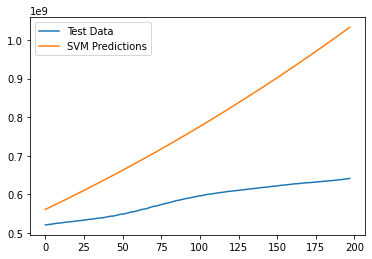

In [72]:
svm_reg = SVR(C=0.1,kernel='poly',gamma=0.01, epsilon=1)
svm_reg.fit(X_train_confirmed, y_train_confirmed)

svm_pred = svm_reg.predict(numbers_start_to_futures[50:].reshape(-1,1))

y_pred = svm_reg.predict(X_test_confirmed)

# Plotting the test data and svm predictions
plt.plot(y_test_confirmed)
plt.plot(y_pred)
plt.legend(['Test Data', 'SVM Predictions'])

mae=mean_absolute_error(y_pred, y_test_confirmed)
mse=mean_squared_error(y_pred, y_test_confirmed)
rmse = np.sqrt(mse)
print("RMSE of ", svm_reg.__class__.__name__, round(rmse,2))
print("MAE of ", svm_reg.__class__.__name__, round(mae,2), '\n')

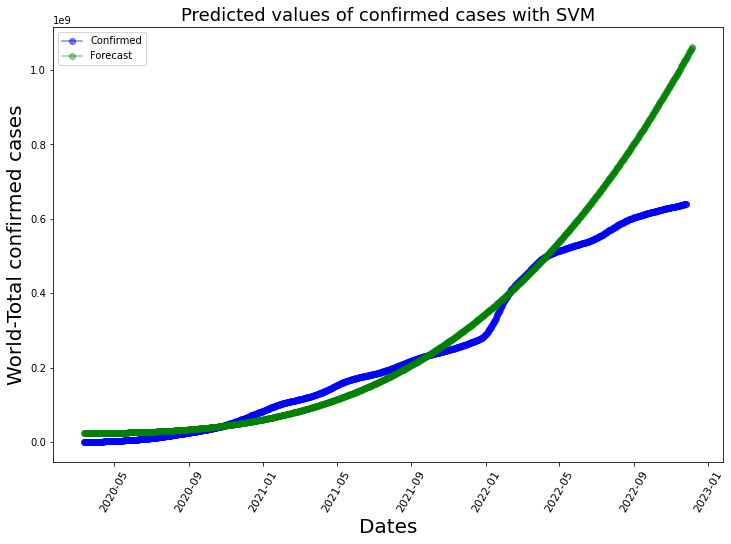

In [117]:
dates = dates_start_to_futures[50:-10]

world_df=covid19_world.iloc[50:,:] 

plt.figure(figsize= (12,8))
plt.xticks(rotation = 60 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('World-Total confirmed cases',fontsize = 20)
plt.title("Predicted values of confirmed cases with SVM" , fontsize = 18)

plt.plot_date(y= world_df['Confirmed'].values, x= dates, label = 'Confirmed',alpha=0.5,linestyle ='-',color = 'blue')
plt.plot_date(y= svm_pred,x= dates_start_to_futures[50:],label = 'Forecast',alpha=0.4,linestyle ='-',color = 'green')
plt.legend()

## Linear Regression (LR) for Total Confirmed cases Prediction Worldwide

coef:  [ 4.79647594e+07 -9.78732134e+05  5.92622899e+03 -1.02751701e+01
  6.52733061e-03]
RMSE of  LinearRegression 446299316.55
MAE of  LinearRegression 379847658.8 



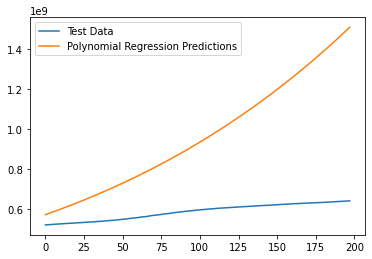

In [74]:
# Changing the training data

poly_features=PolynomialFeatures(degree=4)

poly_X_train_confirmed = poly_features.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly_features.fit_transform(X_test_confirmed)
poly_future_forecast = poly_features.fit_transform(numbers_start_to_futures[50:])

# Fitting a Linear Regression model
lin_reg=LinearRegression(normalize=True, fit_intercept=False)

lin_reg.fit(poly_X_train_confirmed,y_train_confirmed)
coef=lin_reg.coef_
print("coef: ", coef)

y_pred = lin_reg.predict(poly_X_test_confirmed)

poly_pred = lin_reg.predict(poly_future_forecast)

# Plotting the test data and PR predictions
plt.plot(y_test_confirmed)
plt.plot(y_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

# Getting RMSE and MAE 
mae=mean_absolute_error(y_pred, y_test_confirmed)
mse=mean_squared_error(y_pred, y_test_confirmed)
rmse = np.sqrt(mse)
print("RMSE of ", lin_reg.__class__.__name__, round(rmse,2))
print("MAE of ", lin_reg.__class__.__name__, round(mae,2), '\n')

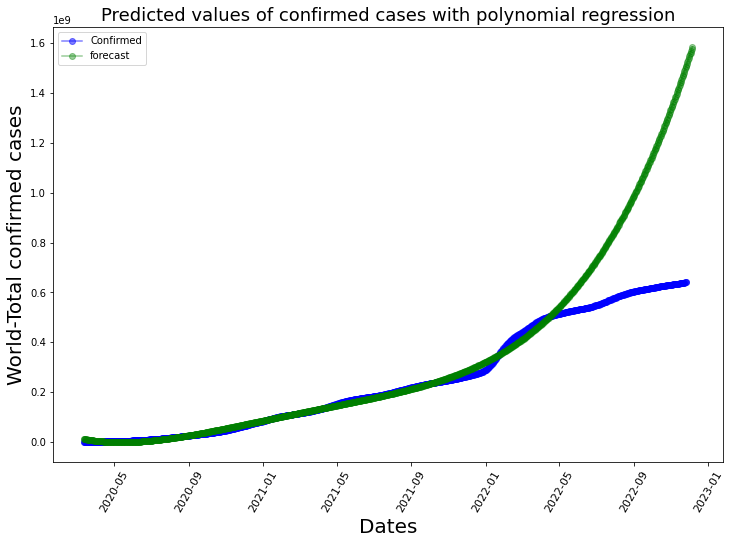

In [118]:
dates = dates_start_to_futures[50:-10]

world_df=covid19_world.iloc[50:,:] 

# Plotting the confirmed and forecast predicted values of confirmed cases
plt.figure(figsize= (12,8))
plt.xticks(rotation = 60 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('World-Total confirmed cases',fontsize = 20)
plt.title("Predicted values of confirmed cases with polynomial regression" , fontsize = 18)

plt.plot_date(y= world_df['Confirmed'].values, x= dates, label = 'Confirmed',alpha=0.5,linestyle ='-',color = 'blue')
plt.plot_date(y= poly_pred,x= dates_start_to_futures[50:],label = 'forecast',alpha=0.4,linestyle ='-',color = 'green')
plt.legend()

## Random Forests Regressor for Total Confirmed cases Prediction Worldwide

RMSE of  RandomForestRegressor 77709776.21
MAE of  RandomForestRegressor 67594423.65 



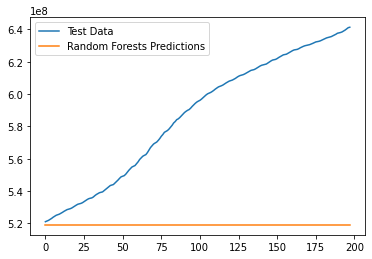

In [76]:
rf_reg = RandomForestRegressor(max_depth=7,n_estimators=5000, random_state=42)

rf_reg.fit(X_train_confirmed, y_train_confirmed)

rf_pred = rf_reg.predict(numbers_start_to_futures[50:].reshape(-1,1))

y_pred = rf_reg.predict(X_test_confirmed)

# Plotting test data and RF predictions
plt.plot(y_test_confirmed)
plt.plot(y_pred)
plt.legend(['Test Data', 'Random Forests Predictions'])

# Getting RMSE and MAE
mae=mean_absolute_error(y_pred, y_test_confirmed)
mse=mean_squared_error(y_pred, y_test_confirmed)
rmse = np.sqrt(mse)
print("RMSE of ", rf_reg.__class__.__name__, round(rmse,2))
print("MAE of ", rf_reg.__class__.__name__, round(mae,2), '\n')

In [77]:
y_pred

array([5.1899996e+08, 5.1899996e+08, 5.1899996e+08, 5.1899996e+08,
       5.1899996e+08, 5.1899996e+08, 5.1899996e+08, 5.1899996e+08,
       5.1899996e+08, 5.1899996e+08, 5.1899996e+08, 5.1899996e+08,
       5.1899996e+08, 5.1899996e+08, 5.1899996e+08, 5.1899996e+08,
       5.1899996e+08, 5.1899996e+08, 5.1899996e+08, 5.1899996e+08,
       5.1899996e+08, 5.1899996e+08, 5.1899996e+08, 5.1899996e+08,
       5.1899996e+08, 5.1899996e+08, 5.1899996e+08, 5.1899996e+08,
       5.1899996e+08, 5.1899996e+08, 5.1899996e+08, 5.1899996e+08,
       5.1899996e+08, 5.1899996e+08, 5.1899996e+08, 5.1899996e+08,
       5.1899996e+08, 5.1899996e+08, 5.1899996e+08, 5.1899996e+08,
       5.1899996e+08, 5.1899996e+08, 5.1899996e+08, 5.1899996e+08,
       5.1899996e+08, 5.1899996e+08, 5.1899996e+08, 5.1899996e+08,
       5.1899996e+08, 5.1899996e+08, 5.1899996e+08, 5.1899996e+08,
       5.1899996e+08, 5.1899996e+08, 5.1899996e+08, 5.1899996e+08,
       5.1899996e+08, 5.1899996e+08, 5.1899996e+08, 5.1899996e

In [78]:
y_test_confirmed

array([520999033, 521443542, 521819366, 522425765, 523019965, 523767189,
       524353307, 524972818, 525343752, 525661877, 526170888, 526750123,
       527384626, 527888939, 528457135, 528745308, 529022678, 529428860,
       530047375, 530739513, 531264195, 531806150, 532059114, 532325305,
       532761882, 533412143, 534112022, 534676979, 535221125, 535504618,
       535708106, 536271224, 537114703, 537833740, 538355154, 538940258,
       539168747, 539443948, 540234995, 541047251, 541853354, 542625342,
       543383593, 543700309, 543987505, 544912337, 545845642, 546777220,
       547835188, 548771651, 549130495, 549491015, 550389353, 551577997,
       552808194, 553843422, 554827741, 555330692, 555756820, 556865638,
       558060906, 559512235, 560471211, 561486455, 562038433, 562497645,
       563733510, 565257713, 566854689, 567978630, 569057179, 569693730,
       570243597, 571270434, 572442235, 573850379, 574945805, 576301534,
       576876547, 577421717, 578331031, 579506632, 

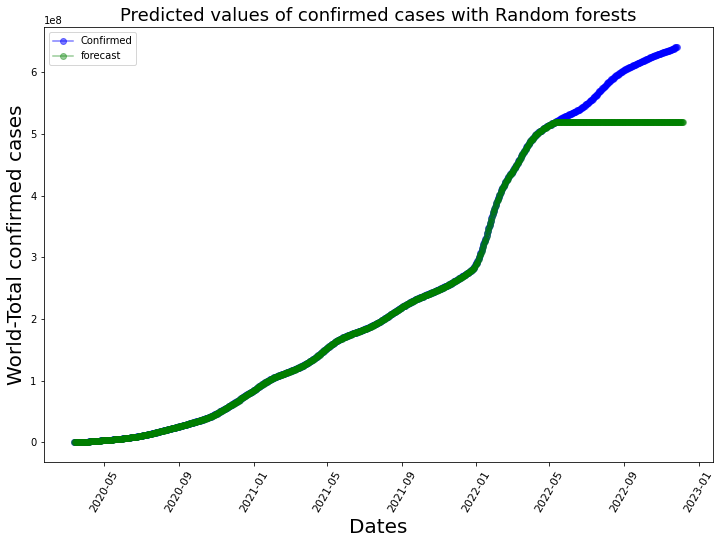

In [119]:
dates = dates_start_to_futures[50:-10]

world_df=covid19_world.iloc[50:,:] 

# Plotting predicted values of confirmed cases
plt.figure(figsize= (12,8))
plt.xticks(rotation = 60 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('World-Total confirmed cases',fontsize = 20)
plt.title("Predicted values of confirmed cases with Random forests" , fontsize = 18)

plt.plot_date(y= world_df['Confirmed'].values, x= dates, label = 'Confirmed',alpha=0.5,linestyle ='-',color = 'blue')
plt.plot_date(y= rf_pred,x= dates_start_to_futures[50:],label = 'forecast',alpha=0.4,linestyle ='-',color = 'green')
plt.legend()

## XGBoost Regressor for Total Confirmed cases Prediction Worldwide

In [80]:
xgb_reg=XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
xgb_reg.fit(X_train_confirmed, y_train_confirmed, early_stopping_rounds=10,
            eval_set=[(X_test_confirmed, y_test_confirmed)],verbose=0)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

RMSE of  XGBRegressor 76486732.83
MAE of  XGBRegressor 66184719.45 



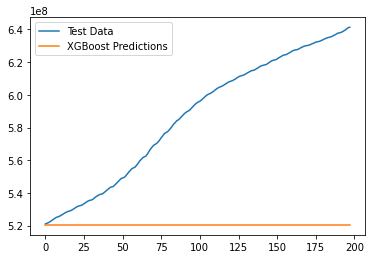

In [81]:
xgb_reg=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1,
             n_estimators=1000, n_jobs=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0)

xgb_reg.fit(X_train_confirmed, y_train_confirmed)

xgb_pred = xgb_reg.predict(numbers_start_to_futures[50:])

y_pred = xgb_reg.predict(X_test_confirmed)

# Plotting test data and XGBoost predictions
plt.plot(y_test_confirmed)
plt.plot(y_pred)
plt.legend(['Test Data', 'XGBoost Predictions'])

# Getting RMSE and MAE
mae=mean_absolute_error(y_pred, y_test_confirmed)
mse=mean_squared_error(y_pred, y_test_confirmed)
rmse = np.sqrt(mse)
print("RMSE of ", xgb_reg.__class__.__name__, round(rmse,2))
print("MAE of ", xgb_reg.__class__.__name__, round(mae,2), '\n')

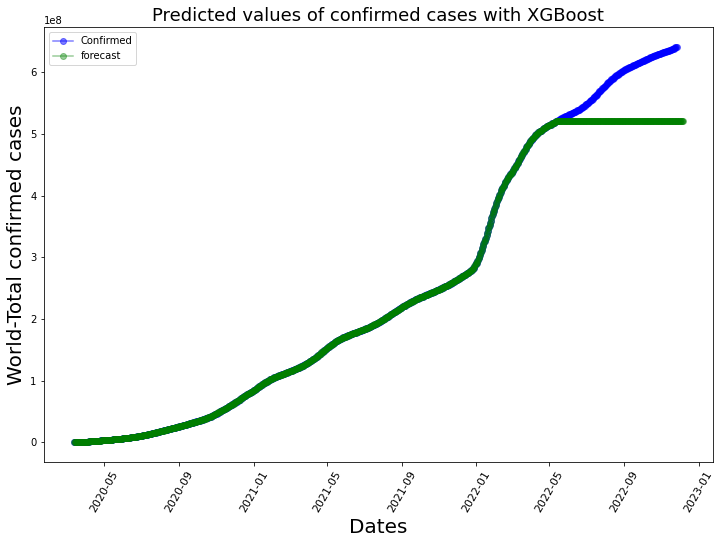

In [120]:
dates = dates_start_to_futures[50:-10]

world_df=covid19_world.iloc[50:,:] 

plt.figure(figsize= (12,8))
plt.xticks(rotation = 60 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('World-Total confirmed cases',fontsize = 20)
plt.title("Predicted values of confirmed cases with XGBoost" , fontsize = 18)

plt.plot_date(y= world_df['Confirmed'].values, x= dates, label = 'Confirmed',alpha=0.5,linestyle ='-',color = 'blue')
plt.plot_date(y= xgb_pred,x= dates_start_to_futures[50:],label = 'forecast',alpha=0.4,linestyle ='-',color = 'green')
plt.legend()

## ARIMA for Total Confirmed cases Prediction Worldwide

In [83]:
model_scores=[]

In [84]:
model_train = covid19_world.iloc[:int(covid19_world.shape[0]*0.95)]
valid = covid19_world.iloc[int(covid19_world.shape[0]*0.95):]
y_pred = valid.copy()

In [85]:
model_arima= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=6,max_q=6,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(model_train["Confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=26714.529, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=26716.512, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=26586.377, Time=0.11 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=26561.695, Time=0.16 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=26443.855, Time=0.26 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=26372.115, Time=0.33 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=26716.519, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=26618.284, Time=0.30 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=26635.343, Time=0.33 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=26451.926, Time=0.32 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=26364.335, Time=0.77 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=26678.721, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=26527.731, Time=0.22 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=26188.053, Time=0.51 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=26765.056, Time=0.37

ARIMA(order=(3, 2, 2), scoring_args={}, suppress_warnings=True)

In [86]:
prediction_arima=model_arima.predict(len(valid))
y_pred["ARIMA Model Prediction"]=prediction_arima

In [87]:
model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_arima)))
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(valid["Confirmed"],prediction_arima)))

Root Mean Square Error for ARIMA Model:  1726247.2252543836


In [88]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Worldwid Confirmed Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases")
fig.show()

## Prophet Model for Total Confirmed cases Prediction Worldwide

14:30:19 - cmdstanpy - INFO - Chain [1] start processing
14:30:20 - cmdstanpy - INFO - Chain [1] done processing


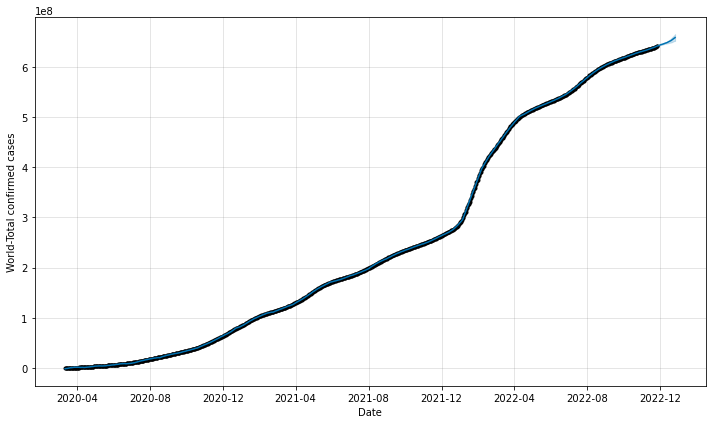

In [112]:
from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
data = pd.DataFrame(columns = ['ds','y'])
data['ds'] = covid19_world['Date'][50:]
data['y'] = covid19_world['Confirmed'][50:].values

prop=Prophet()
prop.fit(data)
future=prop.make_future_dataframe(periods=30)
prop_forecast=prop.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(30)

fig = plot_plotly(prop, prop_forecast)
fig = prop.plot(prop_forecast,xlabel='Date',ylabel='World-Total confirmed cases')


In [91]:
model_names=['ARIMA', 'Linear Regression(LR)','Random Forest(RF)','XGBoost', 'Support Vector Machine(SVM)', 'Facebook Prophet Model']

In [92]:
model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])

In [93]:
model_summary

,Model Name,Root Mean Squared Error
0,ARIMA,1726247.225


# Prediction of Total Deaths cases Worldwide

Above we can see ARIMA Model gives the lowest RMSE

Therefore we can use it for prediction

## ARIMA Model for Deaths Cases Prediction Worldwide

In [94]:
model_train = covid19_world.iloc[:int(covid19_world.shape[0]*0.95)]
valid = covid19_world.iloc[int(covid19_world.shape[0]*0.95):]
y_pred = valid.copy()

In [95]:
model_arima= auto_arima(model_train["Deaths"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=6,max_q=6,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(model_train["Deaths"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=17489.091, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=17487.055, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=17232.955, Time=0.48 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=17219.533, Time=0.14 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=17092.470, Time=0.20 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=17035.701, Time=0.86 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=17489.146, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=17280.278, Time=0.55 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=17225.795, Time=0.92 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=17130.703, Time=0.88 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=17033.531, Time=0.95 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=17434.623, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=17163.211, Time=0.65 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=16929.669, Time=0.83 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=16754.316, Time=0.63

ARIMA(order=(2, 2, 3), scoring_args={}, suppress_warnings=True)

In [96]:
prediction_arima=model_arima.predict(len(valid))
y_pred["ARIMA Model Prediction"]=prediction_arima

In [97]:
model_scores.append(np.sqrt(mean_squared_error(valid["Deaths"],prediction_arima)))
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(valid["Deaths"],prediction_arima)))

Root Mean Square Error for ARIMA Model:  4467.044215884809


In [98]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Deaths"],
                    mode='lines+markers',name="Train Data for Deaths Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Deaths"],
                    mode='lines+markers',name="Validation Data for Deaths Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Deaths Cases",))
fig.update_layout(title="Worldwide Deaths Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Deaths Cases")
fig.show()

# Prediction of Total Confirmed cases for Norway

## ARIMA Model for Confirmed Cases Prediction for Norway

In [99]:
model_train = norway_data.iloc[:int(norway_data.shape[0]*0.95)]
valid = norway_data.iloc[int(norway_data.shape[0]*0.95):]
y_pred = valid.copy()

In [100]:
model_arima= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=6,max_q=6,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(model_train["Confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=16850.743, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=16849.644, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=16711.729, Time=0.29 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=16683.113, Time=0.17 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=16670.720, Time=0.27 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=16576.696, Time=0.77 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=16850.884, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=16760.320, Time=0.52 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=16690.368, Time=0.57 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=16637.250, Time=1.04 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=16553.775, Time=1.52 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=16803.309, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=16638.719, Time=0.36 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.38 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=16245.234, Time=1.38 sec
 

ARIMA(order=(2, 2, 3), scoring_args={}, suppress_warnings=True)

In [102]:
prediction_arima=model_arima.predict(len(valid))
y_pred["ARIMA Model Prediction"]=prediction_arima

In [103]:
model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_arima)))
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(valid["Confirmed"],prediction_arima)))

Root Mean Square Error for ARIMA Model:  841.431040417759


In [104]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Norway Confirmed Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases")
fig.show()

## ARIMA Model for Deaths Cases Prediction for Norway

In [105]:
model_train = norway_data.iloc[:int(norway_data.shape[0]*0.95)]
valid = norway_data.iloc[int(norway_data.shape[0]*0.95):]
y_pred = valid.copy()

In [106]:
model_arima= auto_arima(model_train["Deaths"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=6,max_q=6,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(model_train["Deaths"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=9266.690, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=8587.640, Time=0.21 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=8588.901, Time=0.31 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=8568.230, Time=0.34 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=9028.373, Time=0.09 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=8589.060, Time=0.23 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=8587.687, Time=0.36 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=8584.420, Time=0.60 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=8546.185, Time=0.89 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=8927.012, Time=0.13 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=8580.866, Time=0.47 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=8585.593, Time=0.49 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=8510.284, Time=1.17 sec
 ARIMA(3,2,0)(0,0,0)

ARIMA(order=(2, 2, 3), scoring_args={}, suppress_warnings=True)

In [107]:
prediction_arima=model_arima.predict(len(valid))
y_pred["ARIMA Model Prediction"]=prediction_arima

In [108]:
model_scores.append(np.sqrt(mean_squared_error(valid["Deaths"],prediction_arima)))
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(valid["Deaths"],prediction_arima)))

Root Mean Square Error for ARIMA Model:  97.31992740671218


In [109]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Deaths"],
                    mode='lines+markers',name="Train Data for Deaths Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Deaths"],
                    mode='lines+markers',name="Validation Data for Deaths Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Deaths Cases",))
fig.update_layout(title="Norway Deaths Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Deaths Cases")
fig.show()